# Analysis of forest waste wood in British Columbia

## Background

March 22, 2022

This notebook summarizes observations of waste wood rate (WR) in British Columbia (BC). The objectives included an improved understanding of: 

1) Average values of WR stratified by district;

2) Average values of WR stratified by region (coast or interior);

3) Relationship between WR and harvest yield (m3/ha);

4) Relationship between WR and stand age;

5) Average fractions of dispersed, accumulated (piled), and left standing waste wood

## Methods

The analysis is conducted using a compilation of harvest volume information from the Harvest Billing System (HBS), waste from the Wood Residues and Waste System (WRWS), and stand age from the Vegetation Resource Inventory. The time span ranges from 2007-2021. Although waste information is available at the level of cutblock, harvest volume is not. The analysis was, therefore, conducted at the level of timber mark (TM). Waste for a TM was calculated from a weighted average of waste vaues from one or more cutblocks with different area.

WR is defined as the total avoidable and unavoidable waste wood divided by felled volume. Felled volume was defined as the delivered volume ("Normal Production" of "Logs" in HBS) plus the area-weighted avoidable and unavoidable waste from WRWS. By adopting this definition of WR, the value 1-WR direclty determines the amount of merchantable biomass that is transferred to mills in carbon models.

Stand age at the time of felling was taken from the RESULTS Opening Layer.

In [1]:
# Import modules and prepare notebook settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.io as spio
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
from scipy import stats, linalg
import warnings
from IPython.core.display import display, HTML
from fcgadgets.macgyver import utilities_general as gu
from fcgadgets.cbrunner import cbrun_utilities as cbu
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:80% !important; } .output {align-items: left; }</style>"))

In [2]:
# Graphics parameters
plt.rcParams.update( cbu.Import_GraphicsParameters('FCI_Demo') )
tickl=1.5;

In [3]:
# Import data
dTM=gu.ipickle(r'C:\Users\rhember\Documents\Data\Waste Wood\WasteSummary.pkl')

In [4]:
# Derived variables

# Volume felled (Volume delivered + Waste)
dTM['V Felled m3/ha']=dTM['V Logs Delivered Abs m3/ha']+dTM['V NonLog Delivered Abs m3/ha']+dTM['Waste Total m3/ha']

# Waste ratio
dTM['WR']=dTM['Waste Total m3/ha']/dTM['V Felled m3/ha']

# Sawlog recovery ratio
dTM['Sawlog Ratio']=(dTM['V Logs Delivered Grade 1 m3/ha']+dTM['V Logs Delivered Grade 2 m3/ha'])/dTM['V Logs Delivered m3/ha']

# Region
dTM['Reg']=np.array(['Interior' for _ in range(dTM['TM'].size)],dtype=object)
ind=np.where( (dTM['District']=='DCR') | (dTM['District']=='DNI') | (dTM['District']=='DSI') | \
             (dTM['District']=='DSC') | (dTM['District']=='DSQ') | (dTM['District']=='DQC') | \
             (dTM['District']=='DCK') )[0]
dTM['Reg'][ind]='Coast'

# Discrepency in area values between HBS and WS
dTM['Delta A %']=(dTM['DISTURBANCE_GROSS_AREA']-dTM['Waste Net Area Tot'])/dTM['DISTURBANCE_GROSS_AREA']*100

In [5]:
#dTM.keys()

In [21]:
np.unique(dTM['District'])

array(['', 'DCC', 'DCK', 'DCR', 'DCS', 'DFN', 'DKA', 'DKM', 'DMH', 'DMK',
       'DND', 'DNI', 'DOS', 'DPC', 'DPG', 'DQC', 'DQU', 'DRM', 'DSC',
       'DSE', 'DSI', 'DSQ', 'DSS', 'DVA'], dtype=object)

## Relationship between utilization measures and beetle-related tree mortality for 12 years leading up to harvest

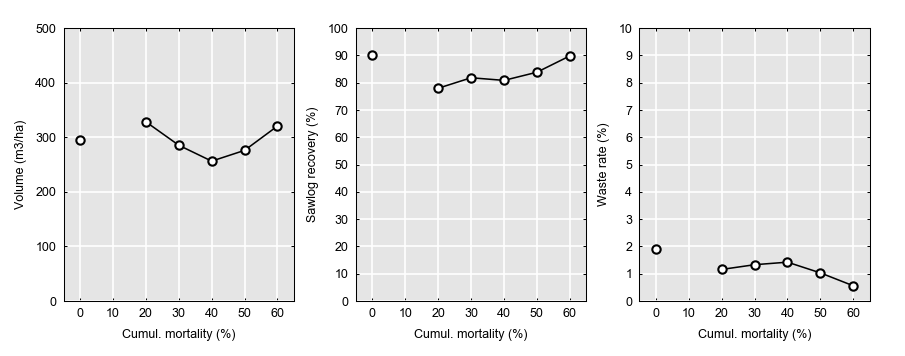

In [24]:
bin=np.arange(0,70,10)
#Dist='DRM'
Dist='DQU'
plt.close('all'); fig,ax=plt.subplots(1,3,figsize=gu.cm2inch(15,5.5)); ms=3; lw=0.5
y=np.zeros(bin.size)
for i in range(bin.size):
    ind=np.where( (np.abs(dTM['D_Beetle']-bin[i])<=5) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['District']==Dist) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['Sawlog Ratio']>=0) & (dTM['Sawlog Ratio']<1) )[0]
    #y[i]=np.nanmean(dTM['Sawlog Ratio'][ind])*100
    y[i]=np.nanmean(dTM['V Logs Delivered m3/ha'][ind])
ax[0].plot(bin,y,'ok-',ms=4,lw=0.75,mfc='w')
ax[0].set(position=[0.06,0.1,0.26,0.84],ylim=[0,500],yticks=np.arange(0,1100,100),ylabel='Volume (m3/ha)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[0].yaxis.set_ticks_position('both'); ax[0].xaxis.set_ticks_position('both'); ax[0].tick_params(length=tickl)

y=np.zeros(bin.size)
for i in range(bin.size):
    ind=np.where( (np.abs(dTM['D_Beetle']-bin[i])<=5) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['District']==Dist) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['Sawlog Ratio']>=0) & (dTM['Sawlog Ratio']<1) )[0]
    y[i]=np.nanmean(dTM['Sawlog Ratio'][ind])*100
ax[1].plot(bin,y,'ok-',ms=4,lw=0.75,mfc='w')
ax[1].set(position=[0.39,0.1,0.26,0.84],ylim=[0,100],yticks=np.arange(0,110,10),ylabel='Sawlog recovery (%)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both'); ax[1].tick_params(length=tickl)

y=np.zeros(bin.size)
for i in range(bin.size):
    ind=np.where( (np.abs(dTM['D_Beetle']-bin[i])<=5) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['District']==Dist) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['Sawlog Ratio']>=0) & (dTM['Sawlog Ratio']<1) )[0]
    y[i]=np.nanmean(dTM['WR'][ind])*100
ax[2].plot(bin,y,'ok-',ms=4,lw=0.75,mfc='w')
ax[2].set(position=[0.71,0.1,0.26,0.84],ylim=[0,10],yticks=np.arange(0,11,1),ylabel='Waste rate (%)', \
          xlim=[-5,65],xticks=np.arange(0,110,10),xlabel='Cumul. mortality (%)')
ax[2].yaxis.set_ticks_position('both'); ax[2].xaxis.set_ticks_position('both'); ax[2].tick_params(length=tickl)

## Summary stats by region

In [7]:
regL=['Coast','Interior']

df=pd.DataFrame( [],
        index=pd.Index(['Volume delivered (m3/ha)','Total waste wood (m3/ha)','Volume felled (m3/ha)', \
                        'WR (%)','WR excluding left standing (%)','Dispersed (%)', \
                        'Accumulation (%)','Left standing (%)'],name='Variables'),
        columns=pd.Index(regL, name='Regions') )

for reg in regL:
    
    ind=np.where( (dTM['Reg']==reg) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) )[0]
    # & (dTM['Tenure Type']=='Forest Licence')
    
    df.loc['Volume delivered (m3/ha)',reg]=np.round(np.mean(dTM['V Logs Delivered m3/ha'][ind]))
    df.loc['Total waste wood (m3/ha)',reg]=np.round(np.mean(dTM['Waste Total m3/ha'][ind]))
    df.loc['Volume felled (m3/ha)',reg]=np.round(np.mean(dTM['V Felled m3/ha'][ind]))
    
    w=dTM['Waste Total m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    vf=dTM['V Felled m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    ind2=np.where(np.isnan(w+vf)==False)[0]
    df.loc['WR (%)',reg]=np.round((np.nansum(w[ind2])/np.nansum(vf[ind2]))*100)
    
    #df.loc['WR (%)',reg]=np.round(np.mean(dTM['WR'][ind])*100)
    #df.loc['WR (%)',reg]=np.round(np.median(dTM['WR'][ind])*100)
    w2=w*(1-dTM['Waste Standing %'][ind]/100)
    df.loc['WR excluding left standing (%)',reg]=np.round((np.nansum(w2[ind2])/np.nansum(vf[ind2]))*100)
    
    df.loc['Dispersed (%)',reg]=np.round(np.nanmean(dTM['Waste Dispersed %'][ind]))
    df.loc['Accumulation (%)',reg]=np.round(np.nanmean(dTM['Waste Accumulation %'][ind]))
    df.loc['Left standing (%)',reg]=np.round(np.nanmean(dTM['Waste Standing %'][ind]))
df

Regions,Coast,Interior
Variables,,
Volume delivered (m3/ha),586,270
Total waste wood (m3/ha),117,12
Volume felled (m3/ha),719,307
WR (%),17,4
WR excluding left standing (%),16,4
Dispersed (%),69,35
Accumulation (%),28,65
Left standing (%),2,1


## Summary by district

In [8]:
regL=list(np.unique(dTM['District']))

df=pd.DataFrame([],
        index=pd.Index(['Volume felled (m3/ha)','WR (%)','Dispersed (%)','Accumulation (%)','Left standing (%)'],name='Variables'),
        columns=pd.Index(regL, name='Regions'))
for reg in regL:
    ind=np.where( (dTM['District']==reg) & \
                 (dTM['Year First']>2006) & \
                 (dTM['V Logs Delivered m3/ha']>0) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Standing %']>=0) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) )[0]
    
    df.loc['Volume felled (m3/ha)',reg]=np.round(np.mean(dTM['V Felled m3/ha'][ind]))
    
    w=dTM['Waste Total m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    vf=dTM['V Felled m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    df.loc['WR (%)',reg]=np.round((np.nansum(w)/np.nansum(vf))*100)
    
    df.loc['Dispersed (%)',reg]=np.round(np.nanmean(dTM['Waste Dispersed %'][ind]))
    df.loc['Accumulation (%)',reg]=np.round(np.nanmean(dTM['Waste Accumulation %'][ind]))
    df.loc['Left standing (%)',reg]=np.round(np.nanmean(dTM['Waste Standing %'][ind]))
df.T

Variables,Volume felled (m3/ha),WR (%),Dispersed (%),Accumulation (%),Left standing (%)
Regions,,,,,
,263,8,35,64,1
DCC,248,4,10,89,1
DCK,568,12,60,38,2
DCR,725,14,74,24,2
DCS,302,2,2,98,0
DFN,301,29,39,61,0
DKA,294,4,17,82,1
DKM,492,20,65,26,10
DMH,233,3,24,75,1


## By Tenure Type

In [9]:
vf_th=0

regL=list(np.unique(dTM['Tenure Type']))[1:]

df=pd.DataFrame([],
        index=pd.Index(['Volume felled (m3/ha)','WR (%)','Dispersed (%)','Accumulation (%)','Left standing (%)'],name='Variables'),
        columns=pd.Index(regL, name='Regions'))
for reg in regL:
    ind=np.where( (dTM['Tenure Type']==reg) & \
                 (dTM['V Felled m3/ha']>=vf_th) & \
                 (dTM['V Felled m3/ha']<1000) & \
                 (dTM['WR']>=0) & (dTM['WR']<=1) )[0]
    df.loc['Volume felled (m3/ha)',reg]=np.round(np.mean(dTM['V Felled m3/ha'][ind]))
    w=dTM['Waste Total m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    vf=dTM['V Felled m3/ha'][ind]*dTM['PLANNED_NET_BLOCK_AREA'][ind]
    df.loc['WR (%)',reg]=np.round((np.nansum(w)/np.nansum(vf))*100)
    df.loc['Dispersed (%)',reg]=np.round(np.nanmean(dTM['Waste Dispersed %'][ind]))
    df.loc['Accumulation (%)',reg]=np.round(np.nanmean(dTM['Waste Accumulation %'][ind]))
    df.loc['Left standing (%)',reg]=np.round(np.nanmean(dTM['Waste Standing %'][ind]))
#df.T

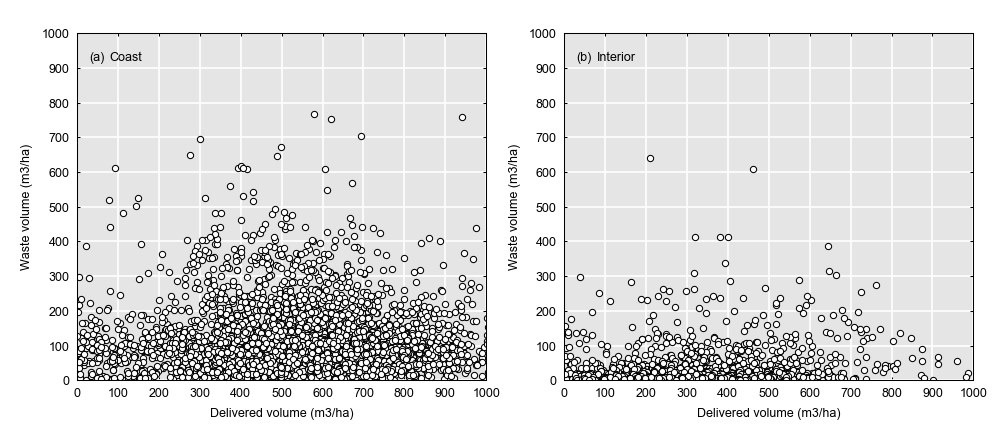

In [10]:
plt.close('all'); fig,ax=plt.subplots(1,2,figsize=gu.cm2inch(16.5,7)); ms=3; lw=0.5

x=dTM['V Logs Delivered m3/ha']
y=dTM['Waste Total m3/ha']
xhat=np.arange(1,1001,1)

ikp=np.where( (dTM['Reg']=='Coast') & \
             (np.abs(dTM['Delta A %'])<100) & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<=1200) & \
             (y>0) & (y<1200) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

ax[0].set(position=[0.07,0.1,0.42,0.84],ylim=[0,1000],yticks=np.arange(0,1200,100),ylabel='Waste volume (m3/ha)', \
          xlim=[0,1000],xticks=np.arange(0,1100,100),xlabel='Delivered volume (m3/ha)')
ax[0].yaxis.set_ticks_position('both'); ax[0].xaxis.set_ticks_position('both'); ax[0].tick_params(length=tickl)

ikp=np.where( (dTM['Reg']=='Interior') & \
             (np.abs(dTM['Delta A %'])<5) & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<=1200) & \
             (y>0) & (y<1200) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[1].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

ax[1].set(position=[0.57,0.1,0.42,0.84],ylim=[0,1000],yticks=np.arange(0,1200,100),ylabel='Waste volume (m3/ha)', \
          xlim=[0,1000],xticks=np.arange(0,1100,100),xlabel='Delivered volume (m3/ha)')
ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both'); ax[1].tick_params(length=tickl)
gu.axletters(ax,plt,0.03,0.92,Labels=['Coast','Interior'],LabelSpacer=0.05)

## Relationship between waste rate and felled volume

In [11]:
def funV(x,a,b,c,d,e):
    y=a+(b-a)*np.exp(-c*x)+d*x+e*x**2
    return y

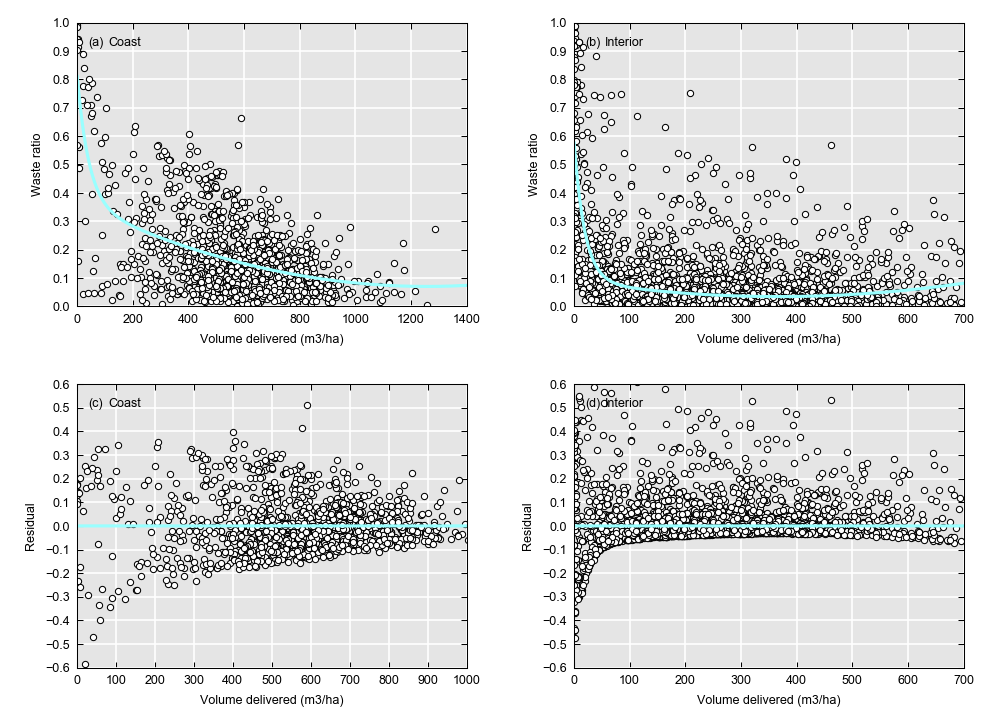

In [20]:
plt.close('all'); fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(16.5,12)); ms=3; lw=0.5

x=dTM['V Logs Delivered m3/ha']+dTM['V NonLog Delivered m3/ha']
y=dTM['WR']

xhat=np.arange(1,2001,1)

ikp=np.where( (dTM['Reg']=='Coast') & \
             (np.abs(dTM['Delta A %'])<5) & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<=2000) & \
             (y>0) & (y<1) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0,0].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

popt,pcov=curve_fit(funV,x0,y0,[3.28729092e-01,9.80527370e-01,2.36993865e-02,-6.96503936e-04,4.73314143e-07])
#print(popt)
yhat=funV(xhat,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[0,0].plot(xhat,yhat,'c-',lw=1.5,color=[0.6,1,1])

#txt='y = ' + str(np.round(md.params[1],decimals=2)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + '\nMean = ' + str(np.round(np.mean(y),decimals=1))
#ax[0].text(290,0.8,txt,ha='right')
ax[0,0].set(position=[0.07,0.58,0.4,0.4],ylim=[0,1],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio', \
          xlim=[0,1400],xticks=np.arange(0,1600,200),xlabel='Volume delivered (m3/ha)')
ax[0,0].yaxis.set_ticks_position('both'); ax[0,0].xaxis.set_ticks_position('both')

y1=y0-funV(x0,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[1,0].plot(x0,y1,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y1,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[1,0].plot(xhat,yhat,'c-',color=[0.6,1,1],lw=1.5)

ax[1,0].set(position=[0.07,0.07,0.4,0.4],ylim=[-0.6,0.6],yticks=np.arange(-1,1.1,0.1),ylabel='Residual', \
          xlim=[0,1000],xticks=np.arange(0,1100,100),xlabel='Volume delivered (m3/ha)')
ax[1,0].yaxis.set_ticks_position('both'); ax[1,0].xaxis.set_ticks_position('both')
#==============================================================================================================
ikp=np.where( (dTM['Reg']=='Interior') & \
             (np.abs(dTM['Delta A %'])<5) & \
             (dTM['Waste N Entries']>0) & \
             (x>=0) & (x<=1000) & \
             (y>0) & (y<1) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0,1].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)
popt,pcov=curve_fit(funV,x0,y0,[0.08,1,0.01,-0.001,0.0001])
yhat=funV(xhat,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[0,1].plot(xhat,np.maximum(0.01,yhat),'c-',lw=1.5,color=[0.6,1,1])
#txt='y = ' + str(np.round(md.params[1],decimals=2)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + '\nMean = ' + str(np.round(np.mean(y),decimals=1))
#ax[1].text(290,0.8,txt,ha='right')
ax[0,1].set(position=[0.58,0.58,0.4,0.4],ylim=[0,1],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio', \
          xlim=[0,700],xticks=np.arange(0,1100,100),xlabel='Volume delivered (m3/ha)')
ax[0,1].yaxis.set_ticks_position('both'); ax[0,1].xaxis.set_ticks_position('both')

y1=y0-funV(x0,popt[0],popt[1],popt[2],popt[3],popt[4])
ax[1,1].plot(x0,y1,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y1,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[1,1].plot(xhat,yhat,'c-',color=[0.6,1,1],lw=1.5)

ax[1,1].set(position=[0.58,0.07,0.4,0.4],ylim=[-0.6,0.6],yticks=np.arange(-1,1.1,0.1),ylabel='Residual', \
          xlim=[0,700],xticks=np.arange(0,1100,100),xlabel='Volume delivered (m3/ha)')
ax[1,1].yaxis.set_ticks_position('both'); ax[1,1].xaxis.set_ticks_position('both')
gu.axletters(ax,plt,0.03,0.92,Labels=['Coast','Interior','Coast','Interior'],LabelSpacer=0.05)
#gu.PrintFig(r'C:\Users\rhember\OneDrive - Government of BC\Figures\Waste\WasteRatio_vs_Volume','png',900)


## Relationship between waste rate and stand age

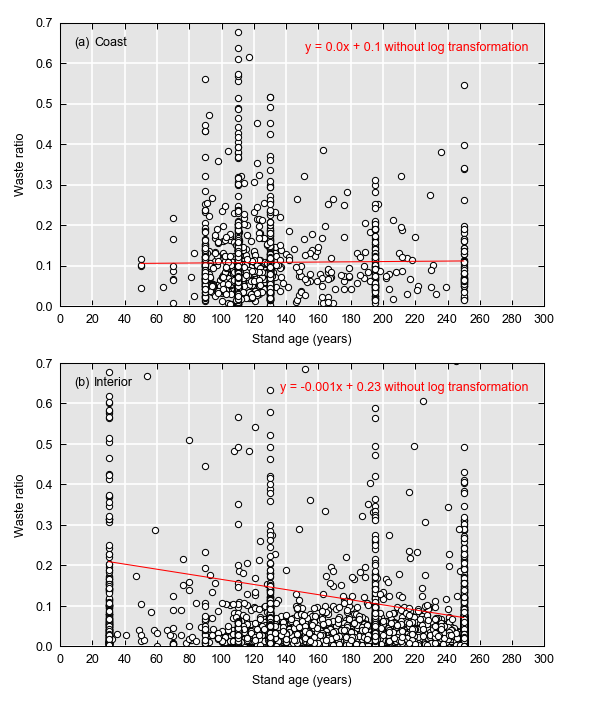

In [13]:
plt.close('all'); fig,ax=plt.subplots(2,1,figsize=gu.cm2inch(10,12)); ms=3; lw=0.5

x=dTM['Age RSLTS WA']
y=dTM['WR']
Ly=np.log(dTM['WR'])

ikp=np.where( (dTM['Reg']=='Coast') & \
              (dTM['Waste N Entries']>0) & \
              (x>0) & (x<1000) & \
              (y>0) & (y<1) & \
              (Ly>-20) & (Ly<=20) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[0].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y0,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[0].plot(xhat,yhat,'r-',lw=lw)
txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' without log transformation'
ax[0].text(290,0.63,txt,ha='right',color='r')

#x0=x[ikp]
#y0=Ly[ikp]
#x1=sm.tools.tools.add_constant(x0)
#md=sm.OLS(y0,x1).fit()
#md.summary()
#xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
#yhat=np.exp(md.predict(np.c_[np.ones(xhat.size),xhat]))
#ax[0].plot(xhat,yhat,'b-',lw=lw)
#txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' with log transformation'
#ax[0].text(290,0.58,txt,ha='right',color='b')

ax[0].set(position=[0.08,0.58,0.82,0.4],ylim=[0,0.7],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio',xlim=[0,300],xticks=np.arange(0,400,20),xlabel='Stand age (years)')
ax[0].yaxis.set_ticks_position('both'); ax[0].xaxis.set_ticks_position('both')

ikp=np.where( (dTM['Reg']=='Interior') & \
             (dTM['Waste N Entries']>0) & \
             (x>0) & (x<1000) & \
             (y>=0) & (y<=1) & \
             (Ly>-20) & (Ly<=20) )[0]
# & (dTM['Tenure Type']=='Forest Licence')
x0=x[ikp]
y0=y[ikp]
ax[1].plot(x0,y0,'ko',mfc='w',mec='k',ms=ms,lw=lw,mew=lw)

x1=sm.tools.tools.add_constant(x0)
md=sm.OLS(y0,x1).fit()
md.summary()
xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
yhat=md.predict(np.c_[np.ones(xhat.size),xhat])
ax[1].plot(xhat,yhat,'r-',lw=lw)
txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' without log transformation'
ax[1].text(290,0.63,txt,ha='right',color='r')

#x0=x[ikp]
#y0=Ly[ikp]
#x1=sm.tools.tools.add_constant(x0)
#md=sm.OLS(y0,x1).fit()
#md.summary()
#xhat=np.linspace(np.min(x1[:,1]),np.max(x1[:,1]),y.shape[0])
#yhat=np.exp(md.predict(np.c_[np.ones(xhat.size),xhat]))
#ax[1].plot(xhat,yhat,'b-',lw=lw)
#txt='y = ' + str(np.round(md.params[1],decimals=3)) + 'x + ' + str(np.round(md.params[0],decimals=2)) + ' with log transformation'
#ax[1].text(290,0.58,txt,ha='right',color='b')

ax[1].set(position=[0.08,0.1,0.82,0.4],ylim=[0,0.7],yticks=np.arange(0,1.1,0.1),ylabel='Waste ratio',xlim=[0,300],xticks=np.arange(0,400,20),xlabel='Stand age (years)')
ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both')
gu.axletters(ax,plt,0.03,0.92,Labels=['Coast','Interior'],LabelSpacer=0.04)
#gu.PrintFig(r'C:\Users\rhember\OneDrive - Government of BC\Figures\Waste\WasteRatio_vs_StandAge','png',900)

## Waste ratio stratified by year

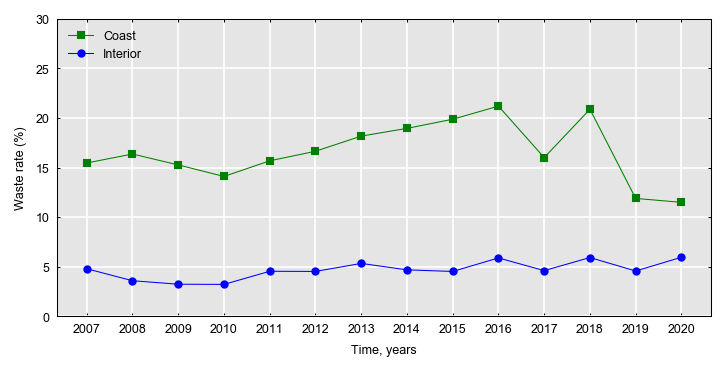

In [14]:
tv=np.arange(2007,2021,1)

plt.close('all'); fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6)); ms=3; lw=0.5

wr=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) & \
                 (dTM['Reg']=='Coast') & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) & \
                 (dTM['V Felled m3/ha']>0) & \
                 (dTM['V Felled m3/ha']<2000) )[0]
    wr[iT]=np.nanmean(dTM['WR'][ind])*100
    
    #w=dTM['Waste Total m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #vf=dTM['V Felled m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #wr[iT]=np.sum(w)/np.sum(vf)*100
    
ax.plot(tv,wr,'-gs',ms=ms,lw=lw,label='Coast')

wr=np.zeros(tv.size)
for iT in range(tv.size):
    ind=np.where( (dTM['Year Last']==tv[iT]) & \
                 (dTM['Reg']=='Interior') & \
                 (dTM['Waste N Entries']>0) & \
                 (np.abs(dTM['Delta A %'])<5) & \
                 (dTM['Waste Net Area Tot']>0) & \
                 (dTM['WR']>=0) & (dTM['WR']<1) & \
                 (dTM['V Felled m3/ha']>0) & 
                 (dTM['V Felled m3/ha']<2000) )[0]
    wr[iT]=np.nanmean(dTM['WR'][ind])*100
    
    #w=dTM['Waste Total m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #vf=dTM['V Felled m3/ha'][ind]*dTM['DISTURBANCE_GROSS_AREA'][ind]
    #wr[iT]=np.sum(w)/np.sum(vf)*100
    
ax.plot(tv,wr,'-bo',ms=ms,lw=lw,label='Interior')
ax.set(ylim=[0,30],ylabel='Waste rate (%)',xticks=np.arange(2007,2021,1),xlabel='Time, years')
ax.yaxis.set_ticks_position('both'); ax.xaxis.set_ticks_position('both'); ax.tick_params(length=1.5)
ax.legend(loc='upper left',facecolor=[1,1,1],frameon=False);